In [1]:
#import library
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from google.colab import drive
drive.mount('drive')

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from glob import glob

import warnings
warnings.filterwarnings('ignore')

Mounted at drive


In [2]:
#Create the dataset
train_dir = 'drive/My Drive/Colab Notebooks/Dataset (2)/Train/'
test_dir = 'drive/My Drive/Colab Notebooks/Dataset (2)/Test/'

In [3]:
def load_img(path):
  x_data = []
  y_data = []

  for folder in glob(path+'/*'):
    for files in tqdm(glob(folder+'/*')):
      arr_img = cv2.imread(files)
      arr_img = cv2.cvtColor(arr_img, cv2.COLOR_BGR2RGB)
      x_data.append(arr_img)
      y_data.append(folder.split("/")[-1])
  
  dataset = pd.DataFrame({'image':x_data, 'label':y_data})
  return dataset

In [4]:
train_dataset = load_img(train_dir)
test_dataset = load_img(test_dir)

100%|██████████| 809/809 [00:14<00:00, 54.80it/s] 


In [5]:
print(train_dataset.shape)
print(test_dataset.shape)

(6440, 2)
(1610, 2)


In [6]:
train_dataset.to_csv('drive/My Drive/Colab Notebooks/train_dataset.csv')
test_dataset.to_csv('drive/My Drive/Colab Notebooks/test_dataset.csv')

In [7]:
#train_dataset.to_csv('drive/My Drive/Colab Notebooks/train_dataset.csv')
#test_dataset.to_csv('drive/My Drive/Colab Notebooks/test_dataset.csv')
train_dataset = pd.read_csv('drive/My Drive/Colab Notebooks/train_dataset.csv', index_col=0)
test_dataset = pd.read_csv('drive/My Drive/Colab Notebooks/test_dataset.csv', index_col=0)

In [8]:
def readin_train(path) :
    """read the csv file in
    
    Args :
        path : project path
        nrows : number of rows to read in
    
    Returns:
        dataset
        
    """
    dtypes = {'Semana' : 'int32',
              'Agencia_ID' :'int32',
              'Canal_ID' : 'int32',
              'Ruta_SAK' : 'int32',
              'Cliente-ID' : 'int32',
              'Producto_ID':'int32',
              'Venta_hoy':'float32',
              'Venta_uni_hoy': 'int32',
              'Dev_uni_proxima':'int32',
              'Dev_proxima':'float32',
              'Demanda_uni_equil':'int32'}
    
    train_dataset = pd.read_csv(path + "/data/raw/train.csv",
                                usecols =['Semana','Agencia_ID','Canal_ID','Ruta_SAK','Cliente_ID','Producto_ID','Demanda_uni_equil'],
                                dtype  = dtypes)
                                
    return train_dataset

In [9]:
train_dataset.head()

,image,label
0,[[[231 254 208]\n [231 254 208]\n [230 253 2...,Organik
1,[[[116 151 57]\n [ 68 103 9]\n [ 70 106 ...,Organik
2,[[[ 0 0 0]\n [ 0 0 0]\n [ 0 0 ...,Organik
3,[[[162 129 88]\n [157 124 83]\n [148 115 ...,Organik
4,[[[241 245 246]\n [241 245 246]\n [241 245 2...,Organik


In [10]:
train_dataset.groupby('label').count()

,image
label,
Anorganik,3072
Organik,3368


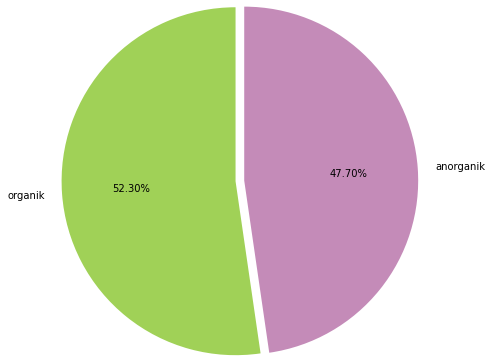

In [11]:
colors = ['#a0d157','#c48bb8']
plt.pie(train_dataset.label.value_counts(), startangle=90, explode=[0.05,0.05], autopct='%0.2f%%', labels=['organik', 'anorganik'], colors=colors, radius=2)
plt.show()

In [12]:
batch_size = 256
target_size = (224,224)
train_img = ImageDataGenerator(rescale= 1./255)
test_img = ImageDataGenerator(rescale= 1./255)

In [13]:
train_gen = train_img.flow_from_directory(
        train_dir, 
        target_size = target_size,
        batch_size = batch_size,
        color_mode = "rgb",
        class_mode = "categorical")

test_gen = test_img.flow_from_directory(
        test_dir, 
        target_size = target_size,
        batch_size = batch_size,
        color_mode = "rgb",
        class_mode = "categorical")

Found 6440 images belonging to 2 classes.
Found 1610 images belonging to 2 classes.


In [14]:
num_classes = 2
input_shape = (224, 224, 3)

In [15]:
#CNN
model = Sequential()

#konvolusi
model.add(Conv2D(32,(3,3),input_shape = input_shape))
model.add(Activation("relu"))

#pooling
model.add(MaxPooling2D())

# Adding a second convolutional layer
model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

# Adding a third convolutional layer
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

#Flattening
model.add(Flatten())

#Full connection
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("sigmoid"))

# Compiling the CNN
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

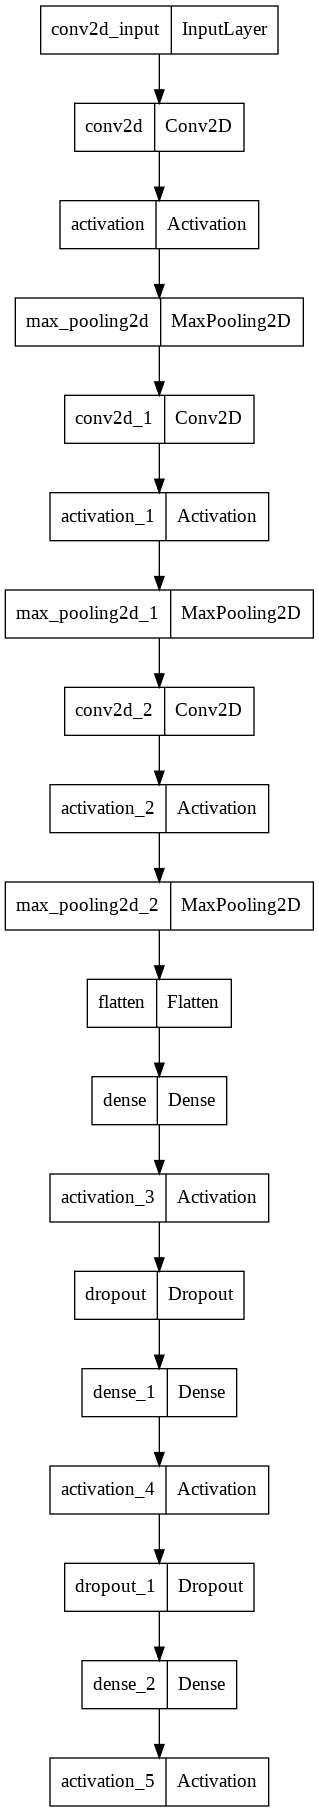

In [16]:
plot_model(model)

In [17]:
savepath = 'drive/My Drive/best_model.hdf5'

In [18]:
checkpoint = ModelCheckpoint(filepath = savepath, 
                             monitor = 'val_loss',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'min')

In [19]:
num_epochs = 10

In [ ]:
hist = model.fit_generator(
        generator = train_gen,
        epochs=num_epochs,
        validation_data = test_gen,
        callbacks = [checkpoint])

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8255 
Epoch 1: val_loss improved from inf to 0.43240, saving model to drive/My Drive/best_model.hdf5
26/26 [==============================] - 660s 25s/step - loss: 0.4354 - accuracy: 0.8255 - val_loss: 0.4324 - val_accuracy: 0.8124
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8413 
Epoch 2: val_loss improved from 0.43240 to 0.37098, saving model to drive/My Drive/best_model.hdf5
26/26 [==============================] - 660s 25s/step - loss: 0.3952 - accuracy: 0.8413 - val_loss: 0.3710 - val_accuracy: 0.8503
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8433 
Epoch 3: val_loss did not improve from 0.37098
26/26 [==============================] - 659s 25s/step - loss: 0.3892 - accuracy: 0.8433 - val_loss: 0.3732 - val_accuracy: 0.8516
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.3538 - accu

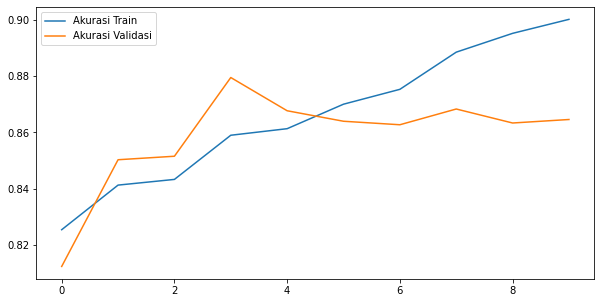

In [22]:
plt.figure(figsize=[10,5])
plt.plot(hist.history["accuracy"], label = "Akurasi Train")
plt.plot(hist.history["val_accuracy"], label = "Akurasi Validasi")
plt.legend()
plt.show()

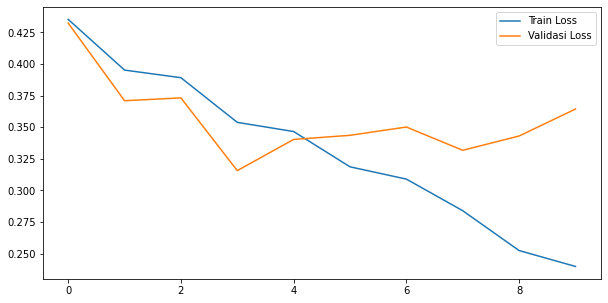

In [23]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Validasi Loss")
plt.legend()
plt.show()

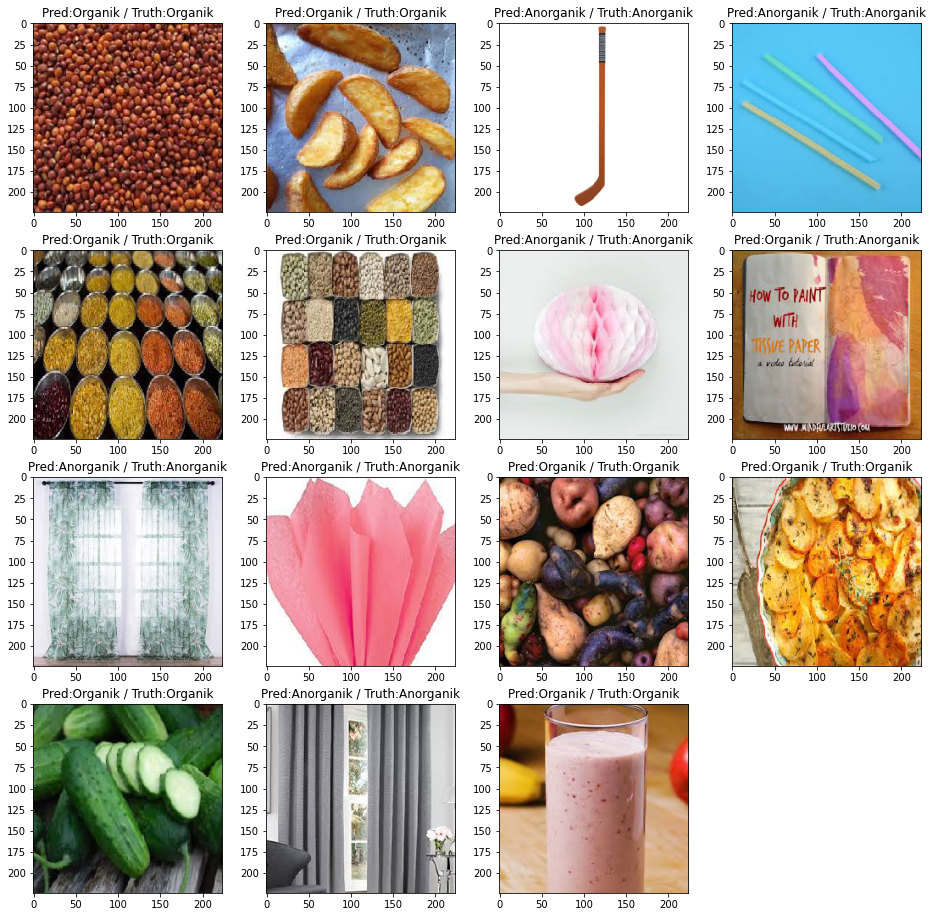

In [24]:
test_x, test_y = test_gen.__getitem__(1)

labels = (test_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('Pred:%s / Truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])